In [1]:
import numpy as np
import pandas as pd
import torch
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

import pickle


%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader, Dataset

import numpy as np
from datasets import DatasetDict
from datasets import load_dataset, load_metric, concatenate_datasets

from hw3 import training


from cs236781.plot import plot_fit
from cs236781.train_results import FitResult

/Users/rondarmon/Documents/deep_learning/hw3/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 4: Fine-Tuning a pretrained language model
<a id=part3></a>

In this part , we will deal with the fine-tuning of BERT for sentiment analysis on the IMDB movie reivews dataset from the previous section.   
BERT is a large language model developed by Google researchers in 2019 that offers a good balance between popularity and model size, which can be fine-tuned using a simple GPU.  

If you aren't yet familiar, you can check it out here:  
https://arxiv.org/pdf/1810.04805.pdf.
(Read Section 3 for details on the model architecture and fine-tuning on downstream tasks).

In particular, we will use the distilled (smaller) version of BERT, called Distil-BERT.
Distil-BERT is widely used in production since it has 40% fewer parameters than BERT, while running 60% faster and retaining 95% of the performance in many benchmarks.
It is recommended to glance through the Distil-BERT paper to get a feel for the model architecture and how it differs from BERT: 
https://arxiv.org/pdf/1910.01108.pdf

We will download a pre-trained `Distil-BERT` from `Hugging Face`, so there is no need to train it from scratch. 

One of the key strengths of Hugging Face is its extensive collection of pre-trained models. These models are trained on large-scale datasets and exhibit impressive performance on various NLP tasks, such as text classification, named entity recognition, sentiment analysis, machine translation, and question answering, among others. The pre-trained models provided by Hugging Face can be easily fine-tuned for specific downstream tasks, saving significant time and computational resources.  


## Loading the Dataset

We will now load and prepare the IMDB dataset as we did in the previous part.  
Here we will load the full training and test set.


In [3]:
dataset = load_dataset('imdb', split=['train', 'test[12260:12740]'])

Found cached dataset imdb (/Users/rondarmon/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
print(dataset)

[Dataset({
    features: ['text', 'label'],
    num_rows: 25000
}), Dataset({
    features: ['text', 'label'],
    num_rows: 480
})]


In [5]:
#wrap it in a DatasetDict to enable methods such as map and format
dataset = DatasetDict({'train': dataset[0], 'test': dataset[1]})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 480
    })
})

We can now access the datasets in the Dict as we would a dictionary.
Let's print a few training samples

In [7]:
for i in range(4):
    print(f'TRAINING SAMPLE {i}:') 
    print(dataset['train'][i]['text'])
    label = dataset['train'][i]['label']
    print(f'Label {i}: {label}')
    print('\n')

TRAINING SAMPLE 0:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few a

We should also check the label distribution:

In [8]:
def label_cnt(type):
    ds = dataset[type]
    size = len(ds)
    cnt= 0 
    for smp in ds:
        cnt += smp['label']
    print(f'negative samples in {type} dataset: {size - cnt}')
    print(f'positive samples in {type} dataset: {cnt}')
    
label_cnt('train')
label_cnt('test')

negative samples in train dataset: 12500
positive samples in train dataset: 12500
negative samples in test dataset: 240
positive samples in test dataset: 240


### __Import the tokenizer for the dataset__


We will now tokenize the text the same way we did in the previous part.



In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print("Tokenizer input max length:", tokenizer.model_max_length)
print("Tokenizer vocabulary size:", tokenizer.vocab_size)

Tokenizer input max length: 512
Tokenizer vocabulary size: 30522


In [10]:
def tokenize_text(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

def tokenize_dataset(dataset):
    dataset_tokenized = dataset.map(tokenize_text, batched=True, batch_size =None)
    return dataset_tokenized

dataset_tokenized = tokenize_dataset(dataset)
# we would like to work with pytorch so we can manually fine-tune
dataset_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# no need to parrarelize in this assignment
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Loading cached processed dataset at /Users/rondarmon/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-2c94583cc9a60a41.arrow
Loading cached processed dataset at /Users/rondarmon/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-12ec9482883ca550.arrow


### Setting up the dataloaders and dataset

We will now set up the dataloaders for efficient batching and loading of the data.  
By now, you are familiar with the Class methods that are needed to create a working Dataloader.


In [11]:
class IMDBDataset(Dataset):
    def __init__(self, dataset):
        self.ds = dataset

    def __getitem__(self, index):
        return self.ds[index]

    def __len__(self):
        return self.ds.num_rows

In [12]:
train_dataset = IMDBDataset(dataset_tokenized['train'])
test_dataset = IMDBDataset(dataset_tokenized['test'])

In [13]:

n_workers= 0

dl_train,dl_test = [ 
    DataLoader(
    dataset=train_dataset,
    batch_size=12,
    shuffle=True, 
    num_workers=n_workers
),
DataLoader(
    dataset=test_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=n_workers
)]

In [14]:
dl_train

## Importing the model from Hugging Face
We will now  delve into the process of loading the DistilBERT model from `Hugging Face`. DistilBERT is a distilled version of the BERT model, offering a lighter and faster alternative while retaining considerable performance on various NLP tasks.  
Please refer to the introduction to check out the relevant papers.  
For more info on how to use this model, feel free to check it out on the site:  
https://huggingface.co/distilbert-base-uncased 



To begin, we will import the necessary library required for our implementation.
It is fine if you receive a warning from `Hugging Face` to train the model on a downstream task, which is exactly what we will do on our IMDB dataset. 

In [15]:
from transformers import AutoModelForSequenceClassification


In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


__Let's print the model architecture to see what we are dealing with:__

In [17]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Fine Tuning
We will now move on to the process of fine-tuning the model that we previously loaded from `Hugging Face`. Fine-tuning allows us to adapt the pre-trained model to our specific NLP task by further training it on task-specific data. This process enhances the model's performance and enables it to make more accurate predictions on our target task.  

There are generally two approaches to fine-tuning the loaded model, each with its own advantages and considerations:  

1) __Freeze all the weights besides the last two linear layers and train only those layers__:  
This approach is commonly referred to as "transfer learning" or "feature extraction." By freezing the weights of the majority of the model's layers, we retain the pre-trained knowledge captured by the model, allowing it to extract useful features from our data. We then replace and train the final few layers, typically linear layers, to adapt the model to our specific task. This method is beneficial when we have limited labeled data or when the pre-trained model has been trained on a similar domain.

2) __Retrain all the parameters in the model__:  
This approach involves unfreezing and training all the parameters of the loaded model, including the pre-trained layers. By retraining all the parameters, we allow the model to adjust its representations and update its knowledge based on our specific task and data. This method is often preferred when we have sufficient labeled data available and want the model to learn task-specific features from scratch or when the pre-trained model's knowledge may not be directly applicable to our domain.

### Fine-tuning method 1 
__Freeze all the weights besides the last two linear layers and train only those layers__



In [18]:
# TODO:
# Freeze all parameters except for the last 2 linear layers
# ====== YOUR CODE: ======
for name, param in model.named_parameters():
    if name not in ('pre_classifier', 'classifier'):
        param.requires_grad = False
# ========================

# HINT: use the printed model architecture to get the layer names




### Training 
We can use our abstract __Trainer__ class to fine-tune the model:
We will not play around with hyperparameters in this section, as the point is to learn to fine-tune a model.   
In addition, we do not need to send our own loss function for this loaded model (try to understand why).   

__TODO__: Implement the `FineTuningTrainer` in `hw3/training.py`

We will train the model for 2 epochs of 40 batches.  
You can run this either locally or on the course servers, whichever is most comfortable for you.

In [19]:
from hw3 import training

optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_last_2.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_last_2', num_epochs=2, max_batches= 40)
    with open('fit_result_finetune_2.pkl', 'wb') as f:
        pickle.dump(fit_result, f)
    

saved_state = torch.load('finetuned_last_2.pt')
model.load_state_dict(saved_state['model_state']) 
best_acc = saved_state['best_acc']
print('best acc:', best_acc)

with open('fit_result_finetune_2.pkl', 'rb') as f:
    fit_result = pickle.load(f) 



best acc: 82.5


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

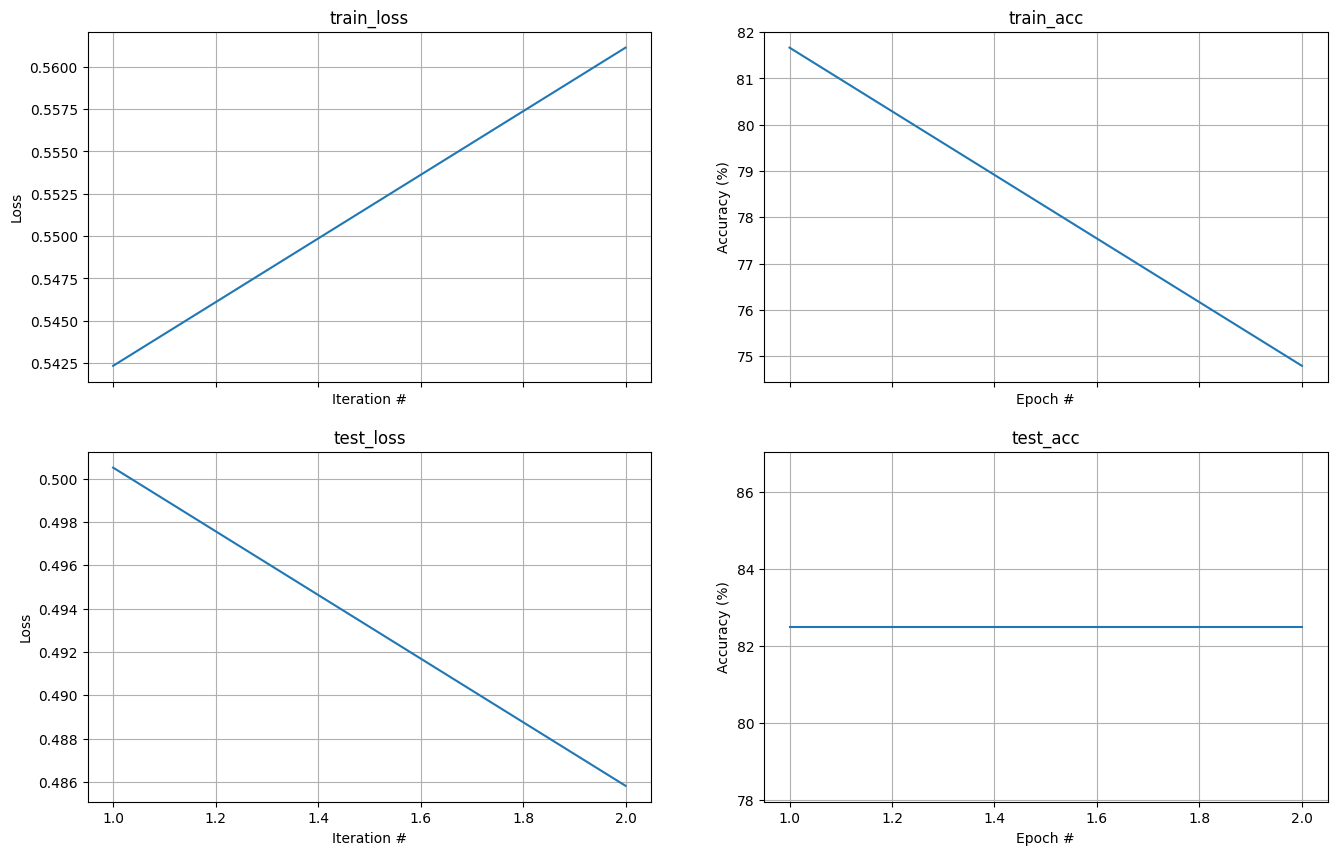

In [20]:
plot_fit(fit_result)

### Fine-tuning method 2 
__Retraining all the parameters in the model__

We will reload the model to ensure that the parameters are untouched and we are starting from scratch

In [21]:
from transformers import AutoModelForSequenceClassification


In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
# TODO: Make sure all the model parameters are unfrozen
# ====== YOUR CODE: ======
for name, param in model.named_parameters():
    param.requires_grad = True
# ========================

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_all.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_all', num_epochs=2, max_batches= 40)
    with open('finetuned_all.pkl', 'wb') as f:
        pickle.dump(fit_result, f)
    

saved_state = torch.load('finetuned_all.pt')
model.load_state_dict(saved_state['model_state']) 

with open('finetuned_all.pkl', 'rb') as f:
    fit_result = pickle.load(f)  


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

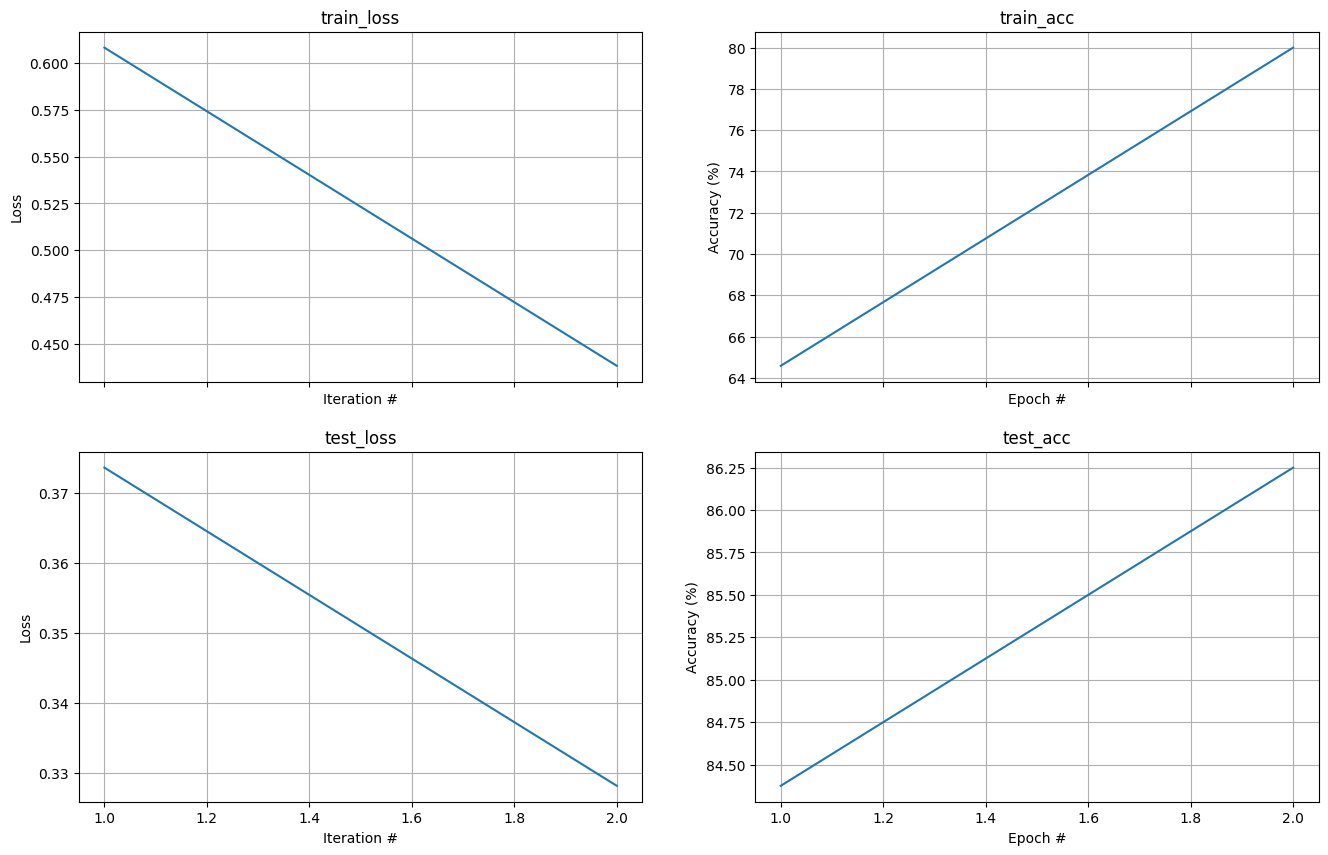

In [26]:
plot_fit(fit_result)

## Questions

Fill out your answers in `hw3.answers.part4_q1` and `hw3.answers.part4_q2`

In [27]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain the results that you got here in comparison to the results achieved in the *trained from scratch* encoder from the preivous part.  
If one of the models performed better, why was this so?   
Will this always be the case on any downstream task, or was this phenomenom specific to this task?


In [28]:
display_answer(hw3.answers.part3_q1)


**Your answer:**
Based on our experimentation with the fine tuning methods, "Unfreezing all layers" (method 2) outperforms The "Unfreeze The Final 2 Linear Layers" (method 1) due to several reasons.
Firstly, by unfreezing all layers, we allowed the model to fine-tune the entire network, including the lower layers responsible for capturing general features and patterns. 
Unfreezing all layers allows the model to adapt and learn from the specific nuances and patterns the may be related to the movie reviews and their sentiment (IMDB dataset).
Secondly, unfreezing all layers provides the model with more parameters to update during fine-tuning. 
The additional flexibility allows the model to better fit the training data, potentially capturing more intricate details and improving overall performance. 

Lastly, the size of the fine-tuning dataset might have influenced the performance.
With only 25k training datapoints and 480 testing datapoints, the model's ability to generalize might be limited.
By unfreezing all layers, the model has more capacity to capture and memorize the training examples, potentially leading to higher accuracy on the limited testing dataset.

It is also worth mentioning that method 2 (unfreezing all layers) took a significantly longer time to train than "Fine-tuning".



### Question 2

Assume that when fine-tuning, instead of freezing the last two linear layers, you instead froze some other internal model layers, such as the multi-headed attention blocks.  
Would the model still be able to succesfully fine-tune to this task?   
Or would the results be worse?  
Explain  

In [29]:
display_answer(hw3.answers.part3_q2)


**Your answer:**
Fine-tuning the internal layers of a model, such as the multi-headed attention blocks, instead of the last two linear layers,
can have different implications on the performance of the model for a specific task.

1. Improved Performance: Fine-tuning internal layers can potentially improve the performance of the model. 
The multi-headed attention blocks are responsible for capturing contextual relationships and dependencies within the input data. 
By fine-tuning these layers, the model can adapt its attention patterns specifically to the task at hand, 
potentially improving its ability to understand and represent relevant information.

2. Degraded Performance: On the other hand, fine-tuning internal layers other than the last two linear layers may negatively impact the performance of the model. 
The last two linear layers are typically responsible for mapping the distilled representation learned by the internal layers to the specific task labels or outputs. 
By not fine-tuning these layers, the model might struggle to effectively utilize the learned representations to make accurate predictions.

3. Task Dependency: The impact of fine-tuning internal layers can also depend on the specific task being performed. 
Some tasks may benefit more from adapting the internal layers, while others may rely more on the final linear layers for performance. 
It is difficult to make a general statement about all possible tasks, as the effectiveness of fine-tuning internal layers would vary based on the specific requirements and characteristics of the task.

In summary, fine-tuning internal layers other than the last two linear layers can have varied outcomes depending on the specific task and data at hand. 
It may lead to improved performance by allowing the model to adapt its attention patterns, 
or it could result in degraded performance by neglecting the mapping of distilled representations to the task labels. 
The ultimate effectiveness of fine-tuning internal layers should be determined empirically through experimentation and validation on the target task.

However, in the case of the IMDB review dataset, fine-tuning the internal layers of the transformer encoder instead of the last two linear layers will potentially harm
the performance because this task is to classify movie reviews as positive or negative (binary classification) and fine tuning the final linear layers will help the model to
learn the mapping between the distilled representation to the task labels. 
Additionally by only fine tuning the internal layers the model will not effectively utilize the learned representations to make accurate predictions.


